In [84]:
import json
import scipy
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as torch_data
import torchvision
import matplotlib.pyplot as plt
from typing import Callable, Sequence

In [44]:
dataset_dir = "../datasets/flowers_2/"

In [16]:
def transforms():
    """ 
    ToTensor: 
        Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] 
        to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]

    Resize:
        Resize the input image to the given size. 
        If the image is torch Tensor, it is expected to have […, H, W] shape
    """
    return torchvision.transforms.Compose([
        torchvision.transforms.Resize((64, 64), interpolation=torchvision.transforms.functional.InterpolationMode.BILINEAR),
        torchvision.transforms.ToTensor(),
    ])

In [29]:
train_dataset = torchvision.datasets.Flowers102(dataset_dir, split="train", transform=transforms(), download=False)
valid_dataset = torchvision.datasets.Flowers102(dataset_dir, split="val", transform=transforms(), download=False)
test_dataset = torchvision.datasets.Flowers102(dataset_dir, split="test", transform=transforms(), download=False)

# Returns the dataset and the labels
train_dataloader = torch_data.DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)

In [21]:
len(train_dataset), len(valid_dataset), len(test_dataset), 

(1020, 1020, 6149)

Text(0.5, 1.0, '68')

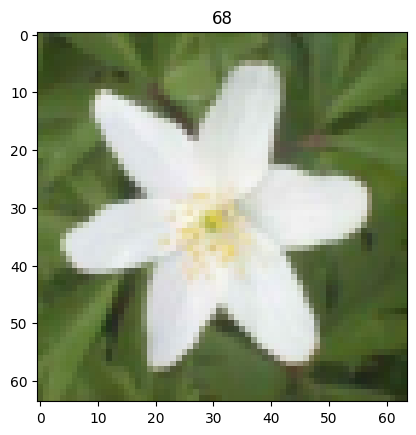

In [50]:
test_batch_data, test_batch_labels = next(iter(train_dataloader))
plt.imshow(test_batch_data[0].permute(1, 2, 0))
plt.title(label=test_batch_labels[0].item())

In [68]:
def linear_diffusion_schedule(min_rate: float, max_rate: float, steps: int) -> list[float]:
    """ Returns the alpha bar values at different time steps based on a linearly increasing schedule """
    betas = min_rate + np.linspace(0.0, 1.0, num=steps) * (max_rate - min_rate)
    alphas = 1 - betas
    return np.cumprod(alphas)

In [71]:
def sinusoid_diffusion_schedule(steps: int) -> list[float]:
    """ Returns the alpha bar values at different time steps using sinusoid schedule."""
    return np.cos(np.linspace(0.0, 1.0, num=steps) * (np.pi / 2)) ** 2

In [72]:
def offset_sinusoid_diffusion_schedule(min_rate: float, max_rate: float, steps: int) -> list[float]:
    """ Returns the alpha bar values at different time steps using sinusoid schedule."""
    start_angle = np.acos(max_rate)
    end_angle = np.acos(min_rate)
    angles = start_angle + np.linspace(0.0, 1.0, num=steps) * (end_angle - start_angle)
    return np.cos(angles) ** 2

Text(0.5, 1.0, 'noise')

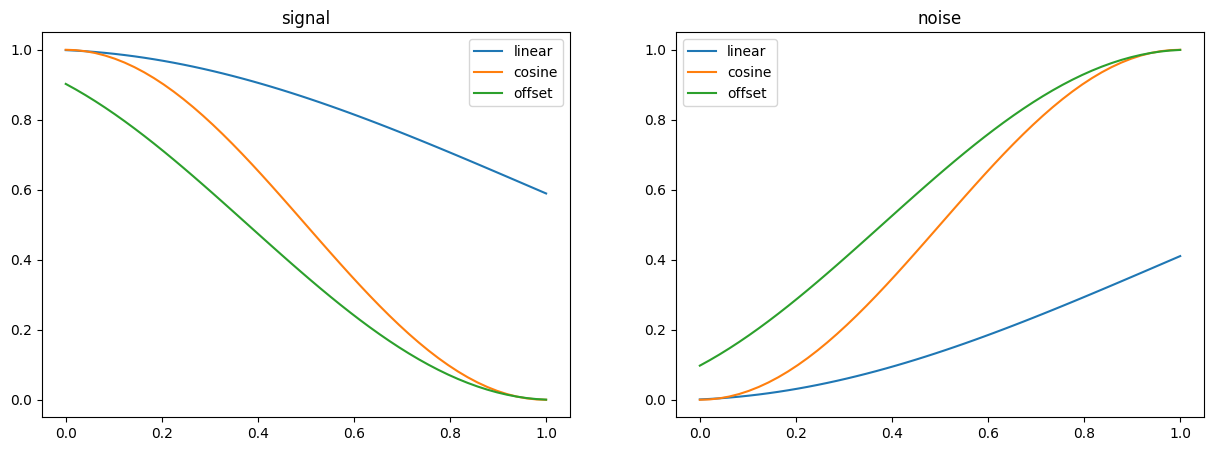

In [233]:
steps = 50
linrates = linear_diffusion_schedule(0.001, 0.02, steps)
cosrates = sinusoid_diffusion_schedule(steps)
offsetrates = offset_sinusoid_diffusion_schedule(0.02, 0.95, steps)
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))
ax1.plot(np.linspace(0, 1, steps), linrates, label="linear")
ax1.plot(np.linspace(0, 1, steps), cosrates, label="cosine")
ax1.plot(np.linspace(0, 1, steps), offsetrates, label="offset")
ax1.legend()
ax1.set_title("signal")

ax2.plot(np.linspace(0, 1, steps), 1 - linrates, label="linear")
ax2.plot(np.linspace(0, 1, steps), 1 - cosrates, label="cosine")
ax2.plot(np.linspace(0, 1, steps), 1 - offsetrates, label="offset")
ax2.legend()
ax2.set_title("noise")

In [234]:
def image_corruption(
    input_image: torch.Tensor, 
    steps: int,
    schedule: Callable[[int], list[float]]
) -> torch.Tensor:
    """ Returns image corrupted at different time steps """
    alpha_bars = torch.Tensor(schedule(steps)).view(steps, 1, 1, 1)
    input_repeated = input_image.repeat((steps, 1, 1, 1))
    gaussian_noise = torch.normal(0.0, 1.0, (steps, input_image.shape[0], input_image.shape[1], input_image.shape[2]))
    images = torch.sqrt(alpha_bars) * input_repeated + torch.sqrt(1 - alpha_bars) * gaussian_noise
    return torch.cat((torch.unsqueeze(input_image, 0), images))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0843031..1.9041255].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8886367..2.6555834].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.413999..3.121037].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.802639..3.7173805].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.7652287..4.060218].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.5441582..3.344053].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.139569..3.9

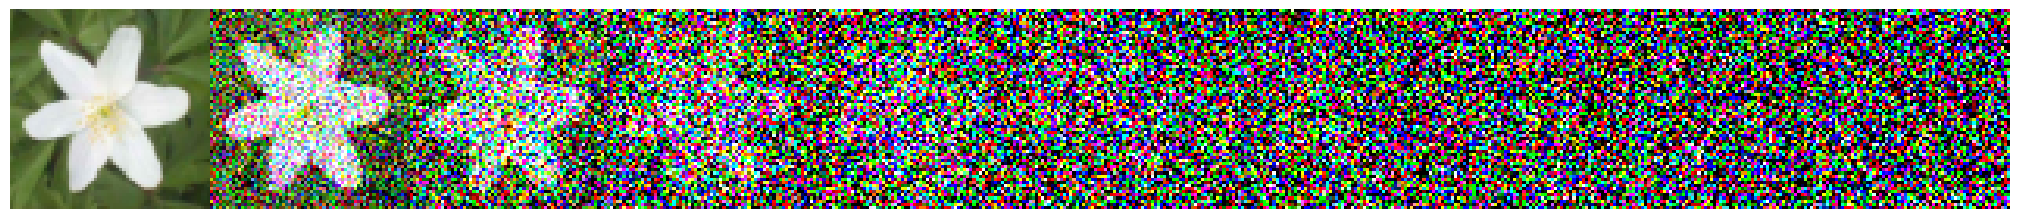

In [240]:
steps = 1000
corrupted_images = image_corruption(test_batch_data[0], steps, lambda s: linear_diffusion_schedule(0.0001, 0.02, s))
f, ax = plt.subplots(1, int(steps / 100), sharey=True, figsize=(20, 3))
for i, a in enumerate(ax):
    min_val = torch.min(corrupted_images[i * 100])
    max_val = torch.max(corrupted_images[i * 100])
    a.imshow(corrupted_images[i * 100].permute(1, 2, 0))
    a.axis("off")

f.tight_layout(pad=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.563736..2.4072943].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8144965..2.7455359].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.319028..2.8816574].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.6702764..2.8142374].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.2088761..3.2611752].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9832659..3.659341].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.6699867..

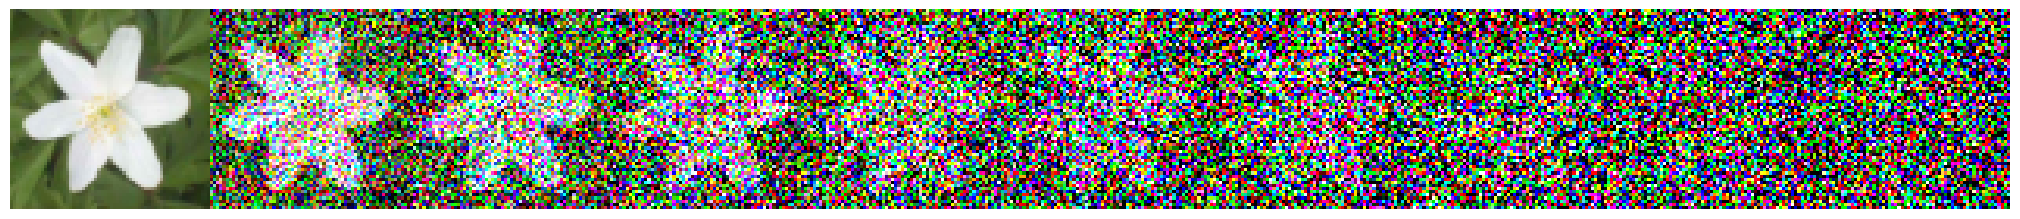

In [243]:
steps = 1000
corrupted_images = image_corruption(test_batch_data[0], steps, lambda s: offset_sinusoid_diffusion_schedule(0.02, 0.95, s))
f, ax = plt.subplots(1, int(steps / 100), sharey=True, figsize=(20, 3))
for i, a in enumerate(ax):
    min_val = torch.min(corrupted_images[i * 100])
    max_val = torch.max(corrupted_images[i * 100])
    a.imshow(corrupted_images[i * 100].permute(1, 2, 0))
    a.axis("off")

f.tight_layout(pad=0)

In [244]:
class DenoisingDiffusionModel(nn.Module):
    pass